In [1]:
import numpy as np
import pandas as pd
import datetime
import random
import pickle
import matplotlib.pyplot as plt
import time as tim
from IPython.display import clear_output
import copy

In [2]:
# 한시간 간격으로 전체 bss에서 호출 나머지는 1과 동일

In [3]:
# # 피클 저장, 로드
# # save
# with open('data.pickle', 'wb') as f:
#     pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

# # load
# with open('data.pickle', 'rb') as f:
#     data = pickle.load(f)

In [4]:
day_n = 999

bike_n = 270
D_size = 42*bike_n*10
# D_terminal_size = 42*bike_n*10


qrate = 0.99
exploration_rate = 0.01
max_w_i = 1
beta = 0.4
beta_zero = 1

base_freq=[3,12,13,10,8,6,6,10,16,16,9,3] # 주문발생빈도 쌍봉형
day_avg = [60, 56, 52, 48, 44, 40, 35, 31, 27, 23] # 하루 평균 주문건수 n그룹
# char_rule=[30, 24, 20, 15, 12] # 배터리 교환 규칙
char_rule=[30, 24, 20, 15, 12] # 배터리 교환 규칙
# 10 25 50 85 100

fit_count=0

time_char_rule=[]

hochool_gijoon = 50 # 호출하는 바이크 배터리 기준
gaa = 0.4
order_limit_r=1500

bss_n = 30 # 고정
interval_sigma = 300 # 배달간격 표준편차 (초단위)
dist_sigma = 300 # 미터단위 배달거리의 표준편차
velo = 40000/3600 # 이륜차 평균속도
velo_sigma = 2 # 이륜차 속도의 표준편차
gene_hyper = 3100
bat_max_wh = 1850 # 배터리 1팩 기준 wh / 1 cycle => 247 감소
bat_max_dist = 35000 # 한 팩 당 총 이동거리
bat_somo = bat_max_wh/bat_max_dist
cycle_loss = 0.247
best_episode_reward=0
TD_error_list=np.array([])
TD_max=1
epsilon = 0.0001

delivery_reward = 1000
n_sample = 32

delivery_count = [0,0,0,0,0,0,0,0,0,0,0,0]

initial_states = []
order_count = np.zeros(day_n+1)

In [5]:
# from keras.callbacks import Callback
# class CustomHistory(Callback):
#     def init(self):
#         self.losses = []
#         self.vol_losses = []
#         self.accs = []
#         self.vol_accs = []

#     def on_epoch_end(self, batch, logs={}):
#         self.losses.append(logs.get('loss'))
# #         self.vol_losses.append(logs.get('vol_loss'))
# #         self.accs.append(logs.get('acc'))
# #         self.vol_accs.append(logs.get('acc_loss'))

## MLP

In [6]:
############ CNN
from tensorflow.keras import backend as K
from tensorflow.keras.backend import expand_dims
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, GlobalAveragePooling1D,Reshape,Embedding, LSTM, Dense,Embedding, concatenate, LSTM,Conv1D, MaxPooling1D, Flatten, Dropout, Lambda, BatchNormalization, Activation
# from keras.layers import merge
from tensorflow.keras import optimizers
from tensorflow.keras import Input
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
tf.device("/device:GPU:0")
def make_model():
    def custom_loss(y_true, y_pred):
        out =  ((y_pred-delta)*y_true)**2
        return K.sum(out)
    # 딥러닝 모델
    #         시간(1), 좌표(2), 충전량(1), 충전소별 큐 길이(30), 충전소별잔여 배터리량(180)
    delta = Input(shape=(1,))
    mask = Input(shape=(2,))

    important_state = Input(shape=(34,),name='important_state')

    bss_state = Input(shape=(120,),name='bss_state')

    other_bike_state = Input(shape=(1,),name='other_bike_state')


    concatenated = concatenate([important_state,bss_state,other_bike_state])

    concatenated = Lambda(lambda x: K.expand_dims(x,axis=2))(concatenated)

    x = Conv1D(filters=75,kernel_size=4, strides=1, activation = 'linear',
    use_bias = False,
               padding = 'same',
#                data_format = "channels_first",
               kernel_regularizer = regularizers.l2(0.0001)
              )(concatenated)
    x = BatchNormalization(axis=1)(x)
    x = LeakyReLU()(x)

    x = Conv1D(filters=75,kernel_size=4, strides=1, activation = 'linear',
    use_bias = False,
               padding = 'same',
#                data_format = "channels_first",
               kernel_regularizer = regularizers.l2(0.0001)
              )(x)
    x = BatchNormalization(axis=1)(x)
    x = LeakyReLU()(x)

    x = Conv1D(filters=75,kernel_size=4, strides=1, activation = 'linear',
    use_bias = False,
               padding = 'same',
#                data_format = "channels_first",
               kernel_regularizer = regularizers.l2(0.0001)
              )(x)
    x = BatchNormalization(axis=1)(x)
    x = LeakyReLU()(x)

    x = Conv1D(filters=75,kernel_size=4, strides=1, activation = 'linear',
    use_bias = False,
               padding = 'same',
#                data_format = "channels_first",
               kernel_regularizer = regularizers.l2(0.0001)
              )(x)
    x = BatchNormalization(axis=1)(x)
    x = LeakyReLU()(x)

    x = Conv1D(filters=75,kernel_size=4, strides=1, activation = 'linear',
    use_bias = False,padding = 'same',
#                data_format = "channels_first",
               kernel_regularizer = regularizers.l2(0.0001))(x)
    x = BatchNormalization(axis=1)(x)
    x = LeakyReLU()(x)

    x = Conv1D(filters=75,kernel_size=4, strides=1, activation = 'linear',
    use_bias = False,padding = 'same',
#                data_format = "channels_first",
               kernel_regularizer = regularizers.l2(0.0001))(x)
    x = BatchNormalization(axis=1)(x)
    x = LeakyReLU()(x)

    x1 = Conv1D(filters=1,kernel_size=1, strides=1, activation = 'linear',
    use_bias = False,padding = 'same',
#                 data_format = "channels_first",
                kernel_regularizer = regularizers.l2(0.0001))(x)
    x1 = BatchNormalization(axis=1)(x1)
    x1 = LeakyReLU()(x1)
    x1 = Flatten()(x1)
    x1 = concatenate([x1,important_state])
    x1 = Dense(20, use_bias = False, activation = 'linear', kernel_regularizer = regularizers.l2(0.0001))(x1)
    x1 = LeakyReLU()(x1)
    value = Dense(1, use_bias = False, activation = 'linear', kernel_regularizer = regularizers.l2(0.0001))(x1)

    x2 = Conv1D(filters=2,kernel_size=1, strides=1, activation = 'linear',
    use_bias = False,padding = 'same',
#                 data_format = "channels_first",
                kernel_regularizer = regularizers.l2(0.0001))(x)
    x2 = BatchNormalization(axis=1)(x2)
    x2 = LeakyReLU()(x2)
    x2 = Flatten()(x2)
    x2 = concatenate([x2,important_state])
    x2 = Dense(20, use_bias = False, activation = 'linear', kernel_regularizer = regularizers.l2(0.0001))(x2)
    x2 = LeakyReLU()(x2)
    advantage = Dense(2, use_bias = False, activation = 'linear', kernel_regularizer = regularizers.l2(0.0001))(x2)

    policy = Lambda(lambda x: x[0]-K.mean(x[0],keepdims=True)+x[1])([advantage, value])
    policy = Lambda(lambda x: x[0]+x[1])([policy, mask])

    model = Model([important_state,bss_state,other_bike_state, mask],[policy])
    train_model = Model([important_state,bss_state,other_bike_state,mask,delta],[policy])
    train_model.compile(optimizer = Adam(lr=0.00005), loss=custom_loss)

    # # opti =  RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

    model.compile(optimizer='rmsprop',loss=['mse'])
    return model, train_model
model, train_model = make_model()
model2, train_model2 = make_model()

model.summary()



2023-07-16 00:15:15.063689: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 00:15:15.072126: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/home/yspark/miniconda3/envs/RL_experiment/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
important_state (InputLayer)    [(None, 34)]         0                                            
__________________________________________________________________________________________________
bss_state (InputLayer)          [(None, 120)]        0                                            
__________________________________________________________________________________________________
other_bike_state (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 155)          0           important_state[0][0]            
                                                                 bss_state[0][0]              

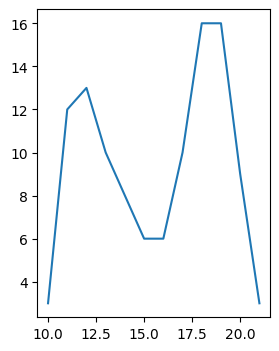

In [7]:
import matplotlib.pyplot as plt
#          10 11 12 13 14 15 16 17 18 19 20 21
# base_freq=[2, 10,13,12, 5, 2, 2,10,16,16,9, 3]
plt.figure(figsize=(3, 4))
plt.plot(range(10,22),base_freq)
plt.show()

In [8]:
# 일초기화에서 위치, status, bat, charge_num, order_freq, order_list, order

class Bike():
    def __init__(self):
        self.key=0
        self.cur_time = 0
        self.loc = (0,0)
        self.fu_loc = (0,0)
        self.ploc=(0,0)
        self.status = 'daegi'
        self.bat = [0,1]
        self.charge_count = 0
        self.order_freq = 2
        self.acc_dist=0
        self.order_list = []
        self.bss_list=[] # [충전소로 출발하는 시간, 충전소 도착할시간, 충전소index, 충전소로 출발할 때 오토바이 위치]
        self.order_count = 0
        self.charge_rule = 50
        self.sooneung = 100
        self.cur_state=[]
        self.action=1
        self.reward=0
        self.fu_state=np.ones(155)
        self.moving_queue_time = 0
        self.stay_queue_time = 0

        self.history = [[self.status, self.cur_time, self.loc, self.acc_dist, self.bat, self.charge_count, self.order_count]] #
        self.moving_queue = 0 # time
    def __lt__(self, other):
        return self.key < other.key

    def decide(self):

        self.ploc = self.loc
        global event_list, state, fubike_idx, hourly_charge_count1, hourly_charge_count2, hourly_charge_count3, hourly_charge_count4
        event_list.pop(0)
        if time < 43200:
            self.reward = 0


            cur_state=[]
            # 현재 시간 주문빈도
            cur_state.append(base_freq[int(time/3600)]/16)
            # 다음 시간 주문 빈도
            if int(time/3600) ==11:
                cur_state.append(base_freq[int(time/3600)]/16)
            # 일종료시점이면 현재시간으로
            else:
                cur_state.append(base_freq[int(time/3600)+1]/16)
            # 본인 배터리 용량
            cur_state.append(battery[self.bat[0]].soc/100)
            # 시간
            cur_state.append(time/43200)
            for i in range(len(bss)):
                # 각 bss 까지의 상대거리 (30)
                cur_state.append(distance(self.loc, bss[i].loc)/5000)


            # bss 정보(90)
            for i in range(len(bss)):
                # 충전소별 큐 길이 (30)
                cur_state.append(len(bss[i].queue)/3)
                # 충전소별 배터리 충전량 (높은 순)(90)
                tmp=[]
                for j in range(2,8,1):
                    battery[bss[i].slot[j]].bat_charge()
                for j in range(2,8,2):
                    tmp.append(battery[bss[i].slot[j]].soc)
                tmp = sorted(tmp,reverse = True)
                for j in range(len(tmp)):
                    cur_state.append(tmp[j]/100)


            # 다른 바이크 정보 (배터리)(1)
            count=0
            for i in range(len(bike)):
                if battery[bike[i].bat[0]].soc < 50:
                    count +=1
            cur_state.append(count)


            tmp=[]
            tmp.append(np.array([cur_state[0:34]]))
            tmp.append(np.array([cur_state[34:154]]))
            tmp.append(np.array([cur_state[154:155]]))
            mask = masking(cur_state)
            tmp.append(np.array([mask]))
            with tf.device('/device:CPU:0'):
                qvalue = model.predict_on_batch(tmp)
            action = np.argmax(qvalue)

            if action==1:
                event_list.insert(0,[time, self, 'order_generate'])
            else:
                # tmp: 가까운 순 정렬
                tmp = []
                for i in range(len(bss)):
                    tmp.append([distance(self.loc, bss[i].loc), i])
                tmp = sorted(tmp)

                action = len(bss)+1
                # 가까운 순 정렬된거로 for문 돌리면서, 교체가능 배터리 있으면 글루 ㄱㄱ, break
                k=0
                while action ==len(bss)+1:
                    for i in range(len(bss)):
                        idx = tmp[i][1]

                        tmp_bss=[]
                        for j in range(2,8,1):
                            battery[bss[idx].slot[j]].bat_charge()
                        for j in range(2,8,2):
                            tmp_bss.append(-battery[bss[idx].slot[j]].soc)
                        tmp_bss = sorted(tmp_bss)
                        if len(bss[idx].queue) < 3:
                            if -tmp_bss[len(bss[idx].queue)] > 99-k:
                                action = idx
    #                             print(1, action)
                                break
                    k+=1
                    if k > 50:
                        action = random.randint(0,29)
                event_list.insert(0,[time, self, 'go_bss',action])
                if battery[self.bat[0]].soc<10:
                    hourly_charge_count1[int(time//3600)] += 1
                elif battery[self.bat[0]].soc < 20:
                    hourly_charge_count2[int(time//3600)] += 1
                elif battery[self.bat[0]].soc < 35:
                    hourly_charge_count3[int(time//3600)] += 1
                elif battery[self.bat[0]].soc < 50:
                    hourly_charge_count4[int(time//3600)] += 1











    def order_generate(self):
        global event_list
#         self.status='daegi'
        interval = gene_hyper/self.order_freq[int(time/3600)]
        gen_inter = np.random.normal(interval,interval_sigma)
        while gen_inter < 0:
            gen_inter = np.random.normal(interval,interval_sigma)
        if time//3600 != (time+gen_inter)//3600:
            if time//3600 != 11:
                interval = gene_hyper/((self.order_freq[int(time/3600)]+self.order_freq[int(time/3600)+1])/2)
            gen_inter = np.random.normal(interval,interval_sigma)
            while gen_inter < 0:
                gen_inter = np.random.normal(interval,interval_sigma)
        max_dist = distance((0,0), self.loc)

        tt=False
        while tt==False:
            gen_dist = np.random.normal(2400,dist_sigma)
            while (gen_dist > 3465)|(gen_dist <max_dist):
                gen_dist = np.random.normal(2400,dist_sigma)

            food_list=[]
            for i in range(len(food_loc)):
                if distance(food_loc[i],self.loc) < gen_dist:
                    food_list.append(i)
            idx = food_list[np.random.randint(len(food_list))]

            x=np.random.random()
            theta = np.random.random()*2*np.pi
            r=gen_dist - distance(food_loc[idx],self.loc)
            house_loc = (food_loc[idx][0]+r*np.cos(theta), food_loc[idx][1]+r*np.sin(theta))

            tt=discri(house_loc)



        tmp_time = gen_inter + time
        self.fu_loc = food_loc[idx]
        event_list.pop(0)
        pickuptime = distance(food_loc[idx],self.loc)/velo
        if tmp_time < 43200:
            if tmp_time - pickuptime <time:
                self.status = 'pickup'
            else:
                for i in range(len(event_list)):
                    if event_list[i][0] > tmp_time-pickuptime:
                        event_list.insert(i,[tmp_time-pickuptime, self, 'change_status_pickup'])
                        break
                    elif i == len(event_list)-1 :
                        event_list.append([tmp_time-pickuptime, self, 'change_status_pickup'])


            for i in range(len(event_list)):
                if event_list[i][0] > tmp_time:
                    event_list.insert(i,[tmp_time, self, 'pickup'])
                    break
                if i == (len(event_list)-1):
                    event_list.append([tmp_time, self, 'pickup'])

            self.order_list.append([tmp_time, food_loc[idx], house_loc, self.loc])


    def pickup(self):
        global event_list
        order = self.order_list[len(self.order_list)-1]

        self.status='delivery'
        self.cur_time= time
        self.loc=order[1]
        self.acc_dist=self.acc_dist+ distance(order[3], order[1])
        self.history.append([self.status, self.cur_time, self.loc, self.acc_dist, self.bat, self.charge_count, self.order_count])
    #     self.soc=self.soc-(self.dist(self.order_list[3], self.order_list[1])/2*bat_somo/bat_max_dist
        tmp_velo = np.random.normal(velo,velo_sigma)
        while (tmp_velo > velo*1.2)|(tmp_velo <velo*0.8):
            tmp_velo = np.random.normal(velo,velo_sigma)

        tmp_time = time + distance(order[1],order[2])/tmp_velo
        self.fu_loc = order[2]
        event_list.pop(0)
        battery[self.bat[0]].bat_consume()
        battery[self.bat[1]].bat_consume()

        for i in range(len(event_list)):
            if event_list[i][0] > tmp_time:
                event_list.insert(i, [tmp_time, self, 'delivery'])
                break
            if i == (len(event_list)-1):
                event_list.append([tmp_time, self, 'delivery'])
    def change_status_pickup(self):
        self.status = 'pickup'
        event_list.pop(0)


    def delivery(self):
        global event_list, order_count

        self.ploc = self.loc
        order = self.order_list[len(self.order_list)-1]
        self.status='delivery'
        self.cur_time= time
        self.loc=order[2]
        self.order_count=self.order_count+1
        order_count[day] += 1
        self.acc_dist=self.acc_dist+ distance(order[1], order[2])
        self.history.append([self.status, self.cur_time, self.loc, self.acc_dist, self.bat, self.charge_count, self.order_count])
        battery[self.bat[0]].bat_consume()
        battery[self.bat[1]].bat_consume()

        self.reward += delivery_reward




#         print(round(time,1),round(battery[self.bat[0]].soc,1),round(battery[self.bat[1]].soc,1))
        if battery[self.bat[0]].soc < 0:
            global terminal, tmp_terminal
#             bike[self.bik].reward = bike[self.bik].reward -2000
            print('oring occured')
            print('day start to termianl : %.1f'%time)
#             terminal = True
#             tmp_terminal = True





        if time//3600 <12:
            delivery_count[int(time//3600)] += 1
        else:
            delivery_count[-1] += 1
        event_list.pop(0)
        event_list.insert(0, [time, self, 'decide'])



    def go_bss(self,tmp_idx):
        global event_list

        self.status='go_bss'

        tmp_velo = np.random.normal(velo,velo_sigma)
        while (tmp_velo > velo*1.2)|(tmp_velo <velo*0.8):
            tmp_velo = np.random.normal(velo,velo_sigma)

        tmp_dist = distance(bss[tmp_idx].loc, self.loc)
        tmp_time = time + tmp_dist/tmp_velo
        self.fu_loc = bss[tmp_idx].loc

        self.bss_list.append([time, tmp_time, tmp_idx, self.loc])



        self.moving_queue_time += tmp_time-time
        event_list.pop(0)
        for i in range(len(event_list)):
            if event_list[i][0]>tmp_time:
                event_list.insert(i,[tmp_time, self, 'arrived_bss', tmp_idx])
                break
            elif i == len(event_list)-1 :
                event_list.append([tmp_time, self, 'arrived_bss', tmp_idx])
        bss[tmp_idx].queue.append([tmp_time,self.key])
#         bss[tmp_idx].queue = sorted(bss[tmp_idx].queue)


    def arrived_bss(self,tmp_idx):
        ######큐 추가#####
        global episode_reward, event_list



        self.status='queue'
        self.cur_time = time
        tmp_bss = self.bss_list[-1]


        self.acc_dist = self.acc_dist + distance(self.loc, bss[tmp_idx].loc)
        self.loc = bss[tmp_idx].loc
        self.history.append([self.status, self.cur_time, self.loc, self.acc_dist, self.bat, self.charge_count, self.order_count])

        battery[self.bat[0]].bat_consume()
        battery[self.bat[1]].bat_consume()

#         print(round(time,1),round(battery[self.bat[0]].soc,1),round(battery[self.bat[1]].soc,1))


#         cur_state=[]
#         cur_state.append(time/43200)
#         cur_state.append(self.loc[0]/3000)
#         cur_state.append(self.loc[1]/3000)
#         cur_state.append(battery[self.bat[0]].soc/100)
#         for i in range(len(bss)):
#             cur_state.append(len(bss[i].queue)/3)
#         for i in range(len(bss)):
#             for j in range(2,8,2):
#                 battery[bss[i].slot[j]].bat_charge()
#                 cur_state.append(battery[bss[i].slot[j]].soc/100)
#         self.fu_state = cur_state
#         self.fu_state = copy.deepcopy(state)
        if battery[self.bat[0]].soc < 0:
            global terminal, tmp_terminal
#             bike[self.bik].reward = bike[self.bik].reward -2000
            print('oring occured')
            print('day start to termianl : %.1f'%time)
#             terminal = True
#             tmp_terminal = True





#         print(self.reward, battery[self.bat[0]].soc)



        event_list.pop(0)
        tmp=False
        for i in range(len(event_list)):
            if (event_list[i][1]== bss[tmp_idx])&(event_list[i][2]=='swap'):
                tmp=True
                break
        if tmp==False:
            event_list.insert(0, [time+0.00001, bss[tmp_idx], 'swap'])

        bss[tmp_idx].count += 1



In [9]:
class Bss():
    def __init__(self):
        self.key=0
        self.queue = []
        self.loc = (0,0)
        self.slot = [None, None, 2,3,4,5,6,7]
        self.bss_history=[]
        self.min_his = []
        self.count=0

    def __lt__(self, other):
        return self.key < other.key

    def swap(self):
        global event_list

#         [status, time, bike[i] or bss[i], self.soc, charge_count]
        for i in range(6):
            idx = i+2
            bat_idx = self.slot[idx]
            battery[bat_idx].bat_charge()

#         if len(self.queue)>1: # 큐 이미 있으면 패스
#             event_list.pop(0)
#         else: #교환가능한거 있으면 교환, 없으면 대기
        tmp_soc = 10
        idx_list=[]
        if len(self.queue)<1:
            event_list.pop(0)
        elif self.queue[0][0]+0.0001>=time:
            event_list.pop(0)

            event_list.insert(0,[self.queue[0][0]+0.001, self, 'swap'])
            event_list = sorted(event_list)

        else:

            for i in range(6):
                idx = i+2
                if tmp_soc*0.99 <= battery[self.slot[idx]].soc:
                    tmp_soc = battery[self.slot[idx]].soc
                    idx_list.insert(0,idx)

            if tmp_soc >= 95:
                bike_idx = self.queue[0][1] # 바이크 인덱스
                idx_list# 배터리 슬롯 인덱스(앞에잇을수록 용량 많음)
                bike_bat = [bike[self.queue[0][1]].bat[0], bike[self.queue[0][1]].bat[1]]#넣은배터리index 2 리스트형
                bat_idx = [self.slot[idx_list[0]],self.slot[idx_list[1]]] # 뺀배터리 index 2 리스트형
                #히스토리업데이트
                #[bike index, bike 도착시간, bike나가는시간, 배터리슬롯index, 넣은배터리index, 뺀배터리index]
                self.bss_history.append([bike_idx, self.queue[0][0], time, [idx_list[0],idx_list[1]], bike_bat, bat_idx])
                #교환
#                 print(self.queue[0][0], time)
                arrived_time = self.queue[0][0]
                self.min_his.append([self.key, bike_idx,day, self.queue[0][0], time - self.queue[0][0]])




                bike[bike_idx].stay_queue_time += time - self.queue[0][0]+60

#                     global terminal, tmp_terminal
#                     tmp_terminal = True
                if time + 60 < 43200:
                    daegitime = time+60 - self.queue[0][0]
                else:
                    daegitime = 43200 - self.queue[0][0]
                if daegitime >3600:
                    global terminal
#                     terminal = True
                    print('so long waited in ', self.key)
                    print('day start to termianl : %.1f'%time)

                self.slot[idx_list[0]]= bike_bat[0]
                self.slot[idx_list[1]]= bike_bat[1]

                bike[bike_idx].bat = bat_idx
                bike[bike_idx].charge_count += 1
                bike[bike_idx].history.append([bike[bike_idx].status, time, bike[bike_idx].loc, bike[bike_idx].acc_dist, bike[bike_idx].bat, bike[bike_idx].charge_count, bike[bike_idx].order_count])
                battery[bat_idx[0]].bik= bike_idx
                battery[bat_idx[0]].bss= None
                battery[bat_idx[0]].charge_count +=1
                battery[bat_idx[1]].bik= bike_idx
                battery[bat_idx[1]].charge_count +=1
                battery[bat_idx[1]].bss= None
                battery[bat_idx[0]].status='on_bike'
                battery[bat_idx[0]].time = time
                battery[bat_idx[1]].time = time
                battery[bat_idx[1]].status='on_bike'
                battery[bat_idx[0]].bat_history.append([battery[bat_idx[0]].status, time, battery[bat_idx[0]].soc,battery[bat_idx[0]].bik,  battery[bat_idx[0]].charge_count])
                battery[bat_idx[1]].bat_history.append([battery[bat_idx[1]].status, time,battery[bat_idx[1]].soc, battery[bat_idx[1]].bik,  battery[bat_idx[1]].charge_count])

                battery[bike_bat[0]].bss = self.key
                battery[bike_bat[0]].status = 'charge'
                battery[bike_bat[0]].time = time
                battery[bike_bat[1]].time = time
                battery[bike_bat[1]].status = 'charge'
                battery[bike_bat[1]].bss = self.key
                battery[bike_bat[0]].bat_history.append([battery[bike_bat[0]].status, time, battery[bike_bat[0]].soc,battery[bike_bat[0]].bik,  battery[bike_bat[0]].charge_count])
                battery[bike_bat[1]].bat_history.append([battery[bike_bat[1]].status, time, battery[bike_bat[1]].soc,battery[bike_bat[1]].bik,  battery[bike_bat[1]].charge_count])


                event_list.pop(0)
                event_list.insert(0,[time+0.01, self, 'swap'])
                event_list.insert(0,[time+60, bike[bike_idx], 'decide'])
                event_list = sorted(event_list)
                self.queue.pop(0)








            else:

                tmp_time = time + (99.5-tmp_soc)*72
                event_list.pop(0)


                event_list.append([tmp_time, self, 'swap'])
                event_list = sorted(event_list)



In [10]:
class Battery():

    def __init__(self):
        self.key=0
        self.so=100
        self.bat_acc=0
        self.status='charge' # 'charge'<100% / 'full'=100% / 'on_bike'
        self.soc=100 # float
        self.bik=0 # bike에 인덱싱
        self.bss=0 # bss에 인덱싱
        self.time=0
        self.cycle=0 # 방전횟수
        self.max_charge=100
        self.charge_count=0 # int
        self.bat_history=[['on_bike', 0, 100, 0, 0]] # [status, time, bike[i] or bss[i], self.soc, charge_count]

    def __lt__(self, other):
        return self.key < other.key

    def bat_consume(self):
        self.status = 'on_bike'
        global terminal

        loc0=bike[self.bik].history[-1][2]
        loc1=bike[self.bik].history[-2][2]
        self.so = self.so - distance(loc0, loc1)/2*bat_somo/bat_max_wh*100
        self.soc = self.so*100/self.max_charge
        self.bat_history.append([self.status, time,self.soc, self.bik, self.charge_count])
#         if (self.soc < 25)&(self.soc>0):
#             if (bike[self.bik].status=='daegi')|(bike[self.bik].status=='pickup')|(bike[self.bik].status=='delivery'):
#                 bike[self.bik].reward = bike[self.bik].reward - (delivery_reward/5)
#                 if self.soc < 20:
#                     bike[self.bik].reward = bike[self.bik].reward - (delivery_reward/5)
#                 if self.soc < 15:
#                     bike[self.bik].reward = bike[self.bik].reward - (delivery_reward/5)
#                 if self.soc < 12:
#                     bike[self.bik].reward = bike[self.bik].reward - (delivery_reward/5)
#                 if self.soc < 9:
#                     bike[self.bik].reward = bike[self.bik].reward - (delivery_reward/5)
#                 if self.soc < 6:
#                     bike[self.bik].reward = bike[self.bik].reward - (delivery_reward/5)
#                 if self.soc < 3:
#                     bike[self.bik].reward = bike[self.bik].reward - (delivery_reward/5)





        if self.soc < 0:
            bike[self.bik].reward = bike[self.bik].reward - (delivery_reward*3)
#             print('day start to termianl : %.1f'%time, end = ' ')
#             terminal = True
#             print('god', end='')

#             update_memory(bike[self.bik].cur_state, bike[self.bik].action, bike[self.bik].reward, bike[self.bik].cur_state, 1000000)


#             model_fit()





    def bat_charge(self):
        self.status='charge'
        if len(self.bat_history)!=0:


            self.bat_acc+=(time-self.bat_history[-1][1])/72
            self.cycle= self.bat_acc/100
#             self.max_charge=100-(cycle_loss*self.cycle)

            self.so = self.so + (time-self.bat_history[-1][1])/72
            if self.so > self.max_charge:
                self.so = self.max_charge
            self.soc = self.so*100/self.max_charge

            self.bat_history.append([self.status, time, self.soc, self.bik, self.charge_count])


<function matplotlib.pyplot.show(close=None, block=None)>

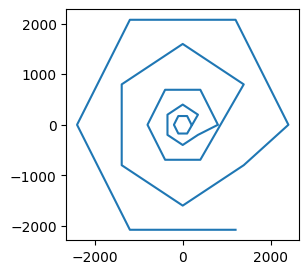

In [11]:
# 충전소 위치
bss_loc=[]
bss_r = [200,400,800,1600,2400]
for j in range(len(bss_r)): # 거리
    for i in range(6): # 각도
        if j%2==0:
            theta = np.pi*i/3
            bss_loc.append((bss_r[j]*np.cos(theta),bss_r[j]*np.sin(theta)))
        if j%2==1:
            theta = np.pi*i/3 + np.pi/6
            bss_loc.append((bss_r[j]*np.cos(theta),bss_r[j]*np.sin(theta)))
df =pd.DataFrame(bss_loc)
plt.figure(figsize=(3, 3))
plt.plot(df[0],df[1])
plt.show


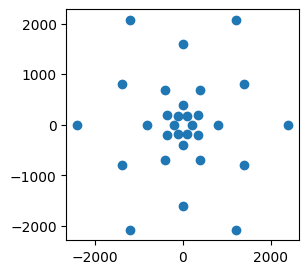

In [12]:
plt.figure(figsize=(3, 3))
plt.scatter(df[0],df[1])
plt.show()

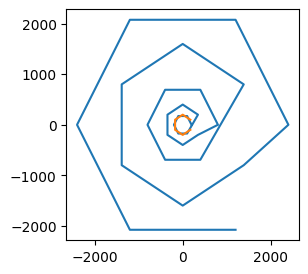

In [13]:
# # 음식점 위치 생성
# food_loc=[]
# n=30 # 음식점 개수
# r=1500
# #반지름 2km 원 위에 고르게 분포


# for i in range(n):
#     theta = 2*i*np.pi/n
#     food_loc.append((r*np.cos(theta), r*np.sin(theta)))
food_loc=[]
bss_r = [200]
for j in range(len(bss_r)): # 거리
    for i in range(6): # 각도
        if j%2==0:
            theta = np.pi*i/3+ np.pi/6
            food_loc.append((bss_r[j]*np.cos(theta),bss_r[j]*np.sin(theta)))
        if j%2==1:
            theta = np.pi*i/3
            food_loc.append((bss_r[j]*np.cos(theta),bss_r[j]*np.sin(theta)))

df =pd.DataFrame(bss_loc)
plt.figure(figsize=(3, 3))
plt.plot(df[0],df[1])
df =pd.DataFrame(food_loc)
plt.plot(df[0],df[1])
plt.show()


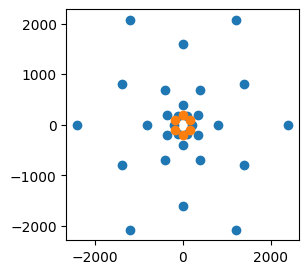

In [14]:
df =pd.DataFrame(bss_loc)
plt.figure(figsize=(3, 3))
plt.scatter(df[0],df[1])
df =pd.DataFrame(food_loc)
plt.scatter(df[0],df[1])
plt.show()

In [15]:
# 육각형 안에 있는지 판별
def discri(a):
    x=a[0]
    y=a[1]
    if (x>=0)&(y>=0): # 1사분면
        tf = (x/np.sqrt(3)+y<3000) & (x<3000)
    elif (x<0)&(y>0): # 2사분면
        tf = (-x/np.sqrt(3)+y<3000) & (x>-3000)
    elif (x<=0)&(y<=0): # 3사분면
        tf = (x>-3000) & (x/np.sqrt(3)+y>-3000)
    elif (x>0)&(y<0):
        tf = (-x/np.sqrt(3)+y>-3000) & (x<3000)
    return tf

# (x,y) 거리 구하기
def distance(x1,x2):
    return np.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2)

def masking(state):
    mask = np.zeros(2)
    # 오링안나기
    if state[2] < 0.12:
        mask[1] = -100
    # 50퍼 전에는 배달만
    if state[2] > 0.5:
        mask[0] = -100
    return mask

In [16]:
#일 종료

def end_day():
    global bike_df,day, bike, battery, bss, terminal
    day_acc_dist = []
    day_order_count = []
    day_charge_count = []
    for i in range(len(bike)):
        bike[i].cur_time=0
        bike_df[i].loc[day,'acc_dist'] = bike[i].acc_dist
        bike[i].acc_dist = 0
        bike_df[i].loc[day,'order_count'] = bike[i].order_count
        bike[i].order_count = 0
        bike_df[i].loc[day,'charge_count'] = bike[i].charge_count
        bike[i].charge_count = 0
        bike_df[i].loc[day,'total_queue_time'] = 0
        bike_df[i].loc[day,'moving_queue_time'] = 0
        bike_df[i].loc[day,'stay_queue_time'] = 0
        bike_df[i].loc[day,'queue_count'] = 0
        bike[i].bss_list = []
#         bike[i].reward=0
        bike[i].history = [[bike[i].status, 0, bike[i].loc, 0, bike[i].bat, 0, 0]]
        if len(bike[i].order_list)<2:
            bike[i].order_list = [[0,[0,0], [0,0], [0,0]],[0,[0,0], [0,0], [0,0]]]
        else:
            bike[i].order_list = [bike[i].order_list[-2],bike[i].order_list[-1]]
    idx = np.arange(0,len(bike))
    random.shuffle(idx)
    j=0
    for i in idx:
        bike[i].order_freq = freq[int(j)]
        j = j + len(freq)/len(bike)
    del idx
#     soc_list=[]
    for i in range(len(battery)):
        battery[i].time=0
        if len(battery[i].bat_history)>0:
#             #[self.status, time,self.soc, self.bik, self.charge_count]
#             soc_list.append(battery[i].bat_history)
            battery[i].bat_history=[[0,0,0,0,0],battery[i].bat_history[-1]]
            battery[i].bat_history[-1][1] = 0
        battery[i].charge_count=0
#     soc_df.append(soc_list)


    for i in range(len(bss)):
        if len(bss[i].bss_history)!=0:
            for j in range(len(bss[i].bss_history)):
                if (bss[i].bss_history[j][2] - bss[i].bss_history[j][1])>0:

                    bike_df[bss[i].bss_history[j][0]].loc[day,'queue_count'] += 1
#                     bike_df[bss[i].bss_history[j][0]].loc[day,'queue_time'] += bss[i].bss_history[j][2] - bss[i].bss_history[j][1]
    min_his_list=[]
    for i in range(len(bss)):
#         if terminal ==False:
        if len(bss[i].queue)>0:
            for j in range(len(bss[i].queue)):
                if (bss[i].queue[j][0]<43200)&(bss[i].queue[j][0]<time):
                    bike_df[bss[i].queue[j][1]].loc[day,'charge_count'] += 1
                    bike_df[bss[i].queue[j][1]].loc[day,'queue_count'] += 1
#                     bike_df[bss[i].queue[j][1]].loc[day,'queue_time'] += time - bss[i].queue[j][0]
                    arrived_time = bss[i].queue[j][0]




                    bike[bss[i].queue[j][1]].stay_queue_time += time - bss[i].queue[j][0]+60

#                     cur_state=[]
#                     cur_state.append(0)
#                     cur_state.append(bike[bss[i].queue[j][1]].loc[0]/3000)
#                     cur_state.append(bike[bss[i].queue[j][1]].loc[1]/3000)
#                     cur_state.append(100/100)
#                     for k in range(len(bss)):
#                         cur_state.append(0)
#                     for k in range(len(bss)):
#                         for l in range(2,8,2):
#                             battery[bss[k].slot[l]].bat_charge()
#                             cur_state.append(100/100)
                    aa=False
                    if time> 43200:
                        aa = True
                    if time<43200:
                        if time - bss[i].queue[j][0] >3600:

                            aa = True
                            print('so long waited in ',bss[i].key)
                            print('day start to termianl : %.1f'%time)
                    else:
                        if 43200 - bss[i].queue[j][0] >3600:

                            aa = True
                            print('so long waited in ',bss[i].key)
                            print('day start to termianl : %.1f'%time)



                ##################################################################################
                    abc = battery[bike[bss[i].queue[j][1]].bat[0]].so
                    battery[bike[bss[i].queue[j][1]].bat[0]].so = battery[bike[bss[i].queue[j][1]].bat[0]].max_charge
                    battery[bike[bss[i].queue[j][1]].bat[0]].soc = 100

                    battery[bike[bss[i].queue[j][1]].bat[0]].bat_acc += battery[bike[bss[i].queue[j][1]].bat[0]].so-abc
                    battery[bike[bss[i].queue[j][1]].bat[0]].cycle= battery[bike[bss[i].queue[j][1]].bat[0]].bat_acc/100
#                     battery[bss[i].slot[k]].max_charge=100-(cycle_loss*battery[bss[i].slot[k]].cycle)
                    battery[bike[bss[i].queue[j][1]].bat[0]].bat_history=[[0,0,0,0,0],[battery[bike[bss[i].queue[j][1]].bat[0]].status, 0, battery[bike[bss[i].queue[j][1]].bat[0]].soc, battery[bike[bss[i].queue[j][1]].bat[0]].bik, battery[bike[bss[i].queue[j][1]].bat[0]].charge_count]]

                    abc = battery[bike[bss[i].queue[j][1]].bat[1]].so
                    battery[bike[bss[i].queue[j][1]].bat[1]].so = battery[bike[bss[i].queue[j][1]].bat[1]].max_charge
                    battery[bike[bss[i].queue[j][1]].bat[1]].soc = 100

                    battery[bike[bss[i].queue[j][1]].bat[1]].bat_acc += battery[bike[bss[i].queue[j][1]].bat[1]].so-abc
                    battery[bike[bss[i].queue[j][1]].bat[1]].cycle= battery[bike[bss[i].queue[j][1]].bat[1]].bat_acc/100
#                     battery[bss[i].slot[k]].max_charge=100-(cycle_loss*battery[bss[i].slot[k]].cycle)
                    battery[bike[bss[i].queue[j][1]].bat[1]].bat_history=[[0,0,0,0,0],[battery[bike[bss[i].queue[j][1]].bat[1]].status, 0, battery[bike[bss[i].queue[j][1]].bat[1]].soc, battery[bike[bss[i].queue[j][1]].bat[1]].bik, battery[bike[bss[i].queue[j][1]].bat[1]].charge_count]]
                ###############################################


        bss[i].bss_history = []
        min_his_list.append(bss[i].min_his)
        bss[i].min_his = []
    min_his_df.append(min_his_list)
    for i in range(len(bss)):
        bss[i].queue = []
    for i in range(len(bike)):
        bike_df[i].loc[day,'stay_queue_time'] = bike[i].stay_queue_time
        bike_df[i].loc[day,'moving_queue_time'] = bike[i].moving_queue_time
        bike_df[i].loc[day,'total_queue_time'] = bike[i].stay_queue_time + bike[i].moving_queue_time
        bike[i].stay_queue_time = 0
        bike[i].moving_queue_time = 0

    for i in range(len(bss)):
        for j in range(6):
            k = j+2
            abc = battery[bss[i].slot[k]].so

            battery[bss[i].slot[k]].so = battery[bss[i].slot[k]].max_charge
            battery[bss[i].slot[k]].soc = 100

            battery[bss[i].slot[k]].bat_acc += battery[bss[i].slot[k]].so-abc
            battery[bss[i].slot[k]].cycle= battery[bss[i].slot[k]].bat_acc/100
#             battery[bss[i].slot[k]].max_charge=100-(cycle_loss*battery[bss[i].slot[k]].cycle)
            battery[bss[i].slot[k]].bat_history=[[0,0,0,0,0],[battery[bss[i].slot[k]].status, 0, battery[bss[i].slot[k]].soc, battery[bss[i].slot[k]].bik, battery[bss[i].slot[k]].charge_count]]

def end_bike_n():

    # 바이크 90대 생성, 주문건수 할당

    #객체 90대 생성
    global bike
    bike = {}
    for i in range(int(bike_n)):
        bike[i] = Bike()
        bike[i].key = i
        bike[i].loc = (4000*random.random()-2000,4000*random.random()-2000)
#         bike[i].sooneung = sooneung_avg

    #base_freq, day_avg 따라 발생빈도 할당
    global freq
    freq = []
    for i in range(len(day_avg)):
        tmp = []
        for j in range(len(base_freq)):
            tmp.append(base_freq[j]*day_avg[i]/sum(base_freq))
        freq.append(copy.deepcopy(tmp))

    idx = np.arange(0,len(bike))
    random.shuffle(idx)
    j=0
    for i in idx:
        bike[i].order_freq = freq[int(j)]
        j = j + len(freq)/len(bike)

        bike[i].bat=[i*2,i*2+1]


    for i in range(len(bike)):
        if i / len(bike)<0.1:
            bike[i].charge_rule = char_rule[0]
        elif i/len(bike)<0.25:
            bike[i].charge_rule = char_rule[1]
        elif i/len(bike)<0.5:
            bike[i].charge_rule = char_rule[2]
        elif i/len(bike)<0.85:
            bike[i].charge_rule = char_rule[3]
        else:
            bike[i].charge_rule = char_rule[4]



    global battery
    battery = {}
    for i in range(int(bike_n)*2+bss_n*6):
        battery[i]=Battery()
        battery[i].key=i
    for i in range(len(bike)):
        battery[i*2].bik = i
        battery[i*2+1].bik = i

#     if popul%10 ==0:
#         for i in range(int(bike_n)):
#             tmp = 100*random.random()+10
#             if tmp >100:
#                 tmp = 100
#     #         tmp = (popul%10)*10+10
#             battery[i*2].so = tmp
#             battery[i*2+1].so = tmp
#     else:
#         for i in range(20):
#             battery[i*2].so = 10
#             battery[i*2+1].so = 10
#         for i in range(20,40):
#             battery[i*2].so = 20
#             battery[i*2+1].so = 20
#         for i in range(40,60):
#             battery[i*2].so = 30
#             battery[i*2+1].so = 30

    #충전소 생성, 위치할당
    global bss
    bss = {}
    for i in range(bss_n):
        bss[i] = Bss()
        bss[i].key = i
        bss[i].slot[2] = i*6 + (2*len(bike))
        bss[i].slot[3] = i*6+1+ (2*len(bike))
        bss[i].slot[4] = i*6+2+ (2*len(bike))
        bss[i].slot[5] = i*6+3+ (2*len(bike))
        bss[i].slot[6] = i*6+4+ (2*len(bike))
        bss[i].slot[7] = i*6+5+ (2*len(bike))
        bss[i].loc = bss_loc[i]

## 처음 돌리기

In [17]:
event_list=[]
state = []
fubike_idx=0
D_memory=[]
# D_terminal=[]

In [18]:
star = tim.time()
for popul in [300]:
    hourly_charge_count1 = np.zeros(12)
    hourly_charge_count2 = np.zeros(12)
    hourly_charge_count3 = np.zeros(12)
    hourly_charge_count4 = np.zeros(12)
    bike_n = popul
    order_count = np.zeros(day_n+1)
#     fit_count = 0
    start = tim.time()
    print('\nepisode',popul)
    episode_reward = 0



    terminal = False
    tmp_terminal = False

    end_bike_n()
    bike_df = []
    for i in range(int(bike_n)):
        bike_df.append(pd.DataFrame(columns=['order_count', 'acc_dist', 'charge_count', 'queue_count', 'moving_queue_time', 'stay_queue_time','total_queue_time']))
    min_his_df = []
    soc_df = []
    #[self.key, bike_idx, self.queue[0][1], time - self.queue[0][1]]


    end_bike_n()
    model.load_weights('model_CDCCDQN4EV_{}.h5'.format(str(bike_n)))
    model2.set_weights(model.get_weights())
    day=0
    while terminal == False:
        sta = tim.time()

        print('day :',day)

        time = 0
        event_list=[]

        for i in range(len(bike)):
            event_list.append([0, bike[i], 'decide'])

        event_list = sorted(event_list)
        while len(event_list)>0:
#             print(len(event_list))



#             event_list = sorted(event_list)
#             print(event_list[0], event_list[0][1].key)

            time = event_list[0][0]

            if len(event_list[0])<4:
                getattr(event_list[0][1],event_list[0][2])()
            elif len(event_list[0])==4:
                getattr(event_list[0][1],event_list[0][2])(event_list[0][3])
            else:
                print('event_list length error')
            if terminal == True:
                break

#             time = event_list[0][0]

        print('\n time for simulate one day : %.1f'%(tim.time()-sta))


        end_day()
        tmp_df = copy.deepcopy(bike_df[0])
        for i in range(1,len(bike_df)):
            tmp_df +=bike_df[i]
        tmp_df = tmp_df/len(bike_df)
        tmp_chargecount = np.mean(tmp_df.iloc[:,2])
        tmp_queuetime1 = np.mean(tmp_df.iloc[:,4])
        tmp_queuetime2 = np.mean(tmp_df.iloc[:,5])
        tmp_queuetime3 = np.mean(tmp_df.iloc[:,6])
        tmp_ordercount = np.mean(tmp_df.iloc[:,0])
        print('\naverage moving queuetime : ',round(tmp_queuetime1/tmp_chargecount,1),round(tmp_df.iloc[-1,4],1))
        print('average stay queuetime : ',round(tmp_queuetime2/tmp_chargecount,1),round(tmp_df.iloc[-1,5],1))
        print('average total queuetime : ',round(tmp_queuetime3/tmp_chargecount,1),round(tmp_df.iloc[-1,6],1))
        print('average chargecount : ',round(tmp_chargecount,1),round(tmp_df.iloc[-1,2],1))
        print('average ordercount : ',round(tmp_ordercount,1),round(tmp_df.iloc[-1,0],1))
        print('total ordercount : ', np.sum(order_count))
        with open('order_count(CDCCDQN4EV)('+str(bike_n)+').pickle', 'wb') as f:
            pickle.dump(order_count, f, pickle.HIGHEST_PROTOCOL)
        hourly_charge_count = [hourly_charge_count1,hourly_charge_count2,hourly_charge_count3,hourly_charge_count4]
        with open('hourly_charge_count(CDCCDQN4EV)('+str(bike_n)+').pickle', 'wb') as f:
            pickle.dump(hourly_charge_count, f, pickle.HIGHEST_PROTOCOL)
        bottom_2 = np.add(hourly_charge_count1, hourly_charge_count2)
        bottom_3 = np.add(bottom_2, hourly_charge_count3)

        # plt.bar(np.arange(10,22), hourly_charge_count1, color = 'dimgray', edgecolor = 'black', label= '~10%')
        # plt.bar(np.arange(10,22), hourly_charge_count2, bottom=hourly_charge_count1, color = 'darkgray', edgecolor = 'black', label= '~20%')
        # plt.bar(np.arange(10,22), hourly_charge_count3, bottom=bottom_2, color = 'lightgrey', edgecolor = 'black', label= '~35%')
        # plt.bar(np.arange(10,22), hourly_charge_count4, bottom=bottom_3, color = 'whitesmoke', edgecolor = 'black', label= '~50%')
        # plt.legend(loc='upper right')
        # plt.show()
        del event_list
        if day == int(day_n):
            terminal = True
            tmp_terminal = True
        day += 1
        # plt.plot(delivery_count)
        # plt.show()



    with open('bike_df_CDCCDQN4EV_{}.pickle'.format(str(bike_n)), 'wb') as f:
        pickle.dump(bike_df, f)
    with open('min_his_df_CDCCDQN4EV_{}.pickle'.format(str(bike_n)), 'wb') as f:
        pickle.dump(min_his_df, f)
#     with open(r'C:\Users\ysp\Dropbox\python_code\zentropy\algo5\\'+str(bike_n)+'soc_his'+str(day_n)+'days.pickle', 'wb') as f:
#         pickle.dump(soc_df, f)
    for i in range(len(min_his_df)):
        tmp_data = min_his_df[i]
        count = [0,0,0,0,0,0,0,0,0,0,0,0]
        for j in range(len(tmp_data)):
            for k in range(len(tmp_data[j])):
                if int(tmp_data[j][k][3]//3600) >11:
                    count[-1] +=1
                else:
                    count[int(tmp_data[j][k][3]//3600)] += 1
#         print(count)
#         plt.plot(count)
#         plt.show()
    print([4,13,12,10,8,7,7,10,16,16,9,4])
    # plt.plot([4,13,12,10,8,7,7,10,16,16,9,4])
    # plt.show()
    cycle_sum = []
    for i in range(len(battery)):
        cycle_sum.append(battery[i].cycle)
    print('cycle : ',np.mean(cycle_sum))
    stop = tim.time()
    print('code start to now : %.1f'%(stop - star))









episode 300
day : 0


2023-07-16 00:15:16.521780: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-07-16 00:15:16.523694: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3593000000 Hz


so long waited in  28
day start to termianl : 42465.0
so long waited in  6
day start to termianl : 43815.4
so long waited in  17
day start to termianl : 44590.4
so long waited in  22
day start to termianl : 44985.0

 time for simulate one day : 92.0

average moving queuetime :  82.0 109.6
average stay queuetime :  996.5 1332.0
average total queuetime :  1078.5 1441.6
average chargecount :  1.3 1.3
average ordercount :  41.2 41.2
total ordercount :  12351.0
day : 1

 time for simulate one day : 92.2

average moving queuetime :  77.8 124.7
average stay queuetime :  706.2 795.9
average total queuetime :  783.9 920.6
average chargecount :  1.5 1.7
average ordercount :  41.3 41.5
total ordercount :  24806.0
day : 2

 time for simulate one day : 94.0

average moving queuetime :  74.0 114.2
average stay queuetime :  621.9 801.2
average total queuetime :  695.9 915.4
average chargecount :  1.6 1.7
average ordercount :  41.3 41.3
total ordercount :  37204.0
day : 3

 time for simulate one day :


 time for simulate one day : 95.7

average moving queuetime :  70.6 146.8
average stay queuetime :  262.2 387.3
average total queuetime :  332.8 534.1
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount :  412964.0
day : 33

 time for simulate one day : 95.4

average moving queuetime :  70.7 120.8
average stay queuetime :  261.1 381.5
average total queuetime :  331.8 502.3
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount :  425492.0
day : 34

 time for simulate one day : 96.7

average moving queuetime :  70.7 121.0
average stay queuetime :  258.8 310.9
average total queuetime :  329.4 431.9
average chargecount :  1.7 1.7
average ordercount :  41.7 42.1
total ordercount :  438132.0
day : 35

 time for simulate one day : 96.9

average moving queuetime :  70.8 132.0
average stay queuetime :  260.5 563.6
average total queuetime :  331.3 695.6
average chargecount :  1.7 1.8
average ordercount :  41.7 41.7
total ordercount :  450647


 time for simulate one day : 99.7

average moving queuetime :  71.2 127.3
average stay queuetime :  270.4 554.0
average total queuetime :  341.5 681.3
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount :  825697.0
day : 66

 time for simulate one day : 99.5

average moving queuetime :  71.2 128.2
average stay queuetime :  271.9 640.9
average total queuetime :  343.1 769.1
average chargecount :  1.7 1.7
average ordercount :  41.7 41.6
total ordercount :  838176.0
day : 67

 time for simulate one day : 99.5

average moving queuetime :  71.2 124.3
average stay queuetime :  272.2 507.7
average total queuetime :  343.4 631.9
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount :  850719.0
day : 68

 time for simulate one day : 99.8

average moving queuetime :  71.2 119.1
average stay queuetime :  273.3 577.9
average total queuetime :  344.5 697.0
average chargecount :  1.7 1.7
average ordercount :  41.7 41.5
total ordercount :  863176


 time for simulate one day : 98.4

average moving queuetime :  71.6 120.1
average stay queuetime :  278.1 452.7
average total queuetime :  349.8 572.7
average chargecount :  1.7 1.8
average ordercount :  41.7 41.7
total ordercount :  1238424.0
day : 99

 time for simulate one day : 99.3

average moving queuetime :  71.6 130.5
average stay queuetime :  280.4 883.8
average total queuetime :  352.1 1014.3
average chargecount :  1.7 1.8
average ordercount :  41.7 41.4
total ordercount :  1250833.0
day : 100

 time for simulate one day : 97.4

average moving queuetime :  71.6 110.7
average stay queuetime :  279.6 316.5
average total queuetime :  351.2 427.2
average chargecount :  1.7 1.6
average ordercount :  41.7 41.8
total ordercount :  1263366.0
day : 101

 time for simulate one day : 98.5

average moving queuetime :  71.6 134.4
average stay queuetime :  281.4 804.9
average total queuetime :  353.0 939.3
average chargecount :  1.7 1.8
average ordercount :  41.7 41.3
total ordercount :  


average moving queuetime :  71.7 121.1
average stay queuetime :  275.4 244.2
average total queuetime :  347.1 365.4
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount :  1638479.0
day : 131

 time for simulate one day : 98.5

average moving queuetime :  71.8 137.9
average stay queuetime :  277.1 845.5
average total queuetime :  348.9 983.4
average chargecount :  1.7 1.7
average ordercount :  41.7 41.2
total ordercount :  1650832.0
day : 132

 time for simulate one day : 99.3

average moving queuetime :  71.8 119.6
average stay queuetime :  277.3 507.9
average total queuetime :  349.1 627.5
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount :  1663331.0
day : 133

 time for simulate one day : 99.2

average moving queuetime :  71.8 112.2
average stay queuetime :  276.6 324.6
average total queuetime :  348.4 436.8
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount :  1675867.0
day : 134

 time for simu


 time for simulate one day : 101.2

average moving queuetime :  71.7 128.6
average stay queuetime :  271.4 886.9
average total queuetime :  343.1 1015.5
average chargecount :  1.7 1.7
average ordercount :  41.7 41.2
total ordercount :  2051563.0
day : 164

 time for simulate one day : 98.2

average moving queuetime :  71.7 114.6
average stay queuetime :  270.4 169.5
average total queuetime :  342.1 284.2
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  2064124.0
day : 165

 time for simulate one day : 99.8

average moving queuetime :  71.7 122.6
average stay queuetime :  270.1 389.9
average total queuetime :  341.8 512.5
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount :  2076678.0
day : 166

 time for simulate one day : 99.9

average moving queuetime :  71.7 124.9
average stay queuetime :  270.2 482.5
average total queuetime :  341.8 607.4
average chargecount :  1.7 1.7
average ordercount :  41.7 41.5
total ordercount :


 time for simulate one day : 99.6

average moving queuetime :  71.5 104.0
average stay queuetime :  270.3 212.0
average total queuetime :  341.8 316.0
average chargecount :  1.7 1.6
average ordercount :  41.7 41.8
total ordercount :  2451669.0
day : 196

 time for simulate one day : 99.4

average moving queuetime :  71.4 109.9
average stay queuetime :  270.0 387.2
average total queuetime :  341.5 497.1
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount :  2464172.0
day : 197

 time for simulate one day : 100.5

average moving queuetime :  71.5 137.4
average stay queuetime :  270.4 564.1
average total queuetime :  341.8 701.5
average chargecount :  1.7 1.7
average ordercount :  41.7 41.6
total ordercount :  2476665.0
day : 198

 time for simulate one day : 101.3

average moving queuetime :  71.5 118.2
average stay queuetime :  271.1 709.6
average total queuetime :  342.6 827.7
average chargecount :  1.7 1.7
average ordercount :  41.7 41.6
total ordercount :


average moving queuetime :  71.4 116.1
average stay queuetime :  267.4 405.1
average total queuetime :  338.8 521.2
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount :  2852293.0
day : 228

 time for simulate one day : 101.3

average moving queuetime :  71.4 119.0
average stay queuetime :  266.9 256.3
average total queuetime :  338.3 375.3
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  2864868.0
day : 229

 time for simulate one day : 101.6

average moving queuetime :  71.4 126.2
average stay queuetime :  267.0 541.5
average total queuetime :  338.5 667.7
average chargecount :  1.7 1.8
average ordercount :  41.7 41.9
total ordercount :  2877429.0
day : 230

 time for simulate one day : 99.6

average moving queuetime :  71.5 135.5
average stay queuetime :  268.2 923.8
average total queuetime :  339.7 1059.3
average chargecount :  1.7 1.7
average ordercount :  41.7 41.3
total ordercount :  2889831.0
day : 231

 time for s


 time for simulate one day : 99.3

average moving queuetime :  71.6 125.0
average stay queuetime :  267.2 464.4
average total queuetime :  338.7 589.4
average chargecount :  1.7 1.7
average ordercount :  41.7 41.6
total ordercount :  3265324.0
day : 261

 time for simulate one day : 100.5

average moving queuetime :  71.6 131.6
average stay queuetime :  267.4 577.5
average total queuetime :  339.0 709.0
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount :  3277852.0
day : 262

 time for simulate one day : 100.9

average moving queuetime :  71.6 118.0
average stay queuetime :  267.3 386.2
average total queuetime :  338.9 504.2
average chargecount :  1.7 1.6
average ordercount :  41.7 41.6
total ordercount :  3290327.0
day : 263

 time for simulate one day : 100.8

average moving queuetime :  71.6 131.4
average stay queuetime :  268.0 789.9
average total queuetime :  339.6 921.2
average chargecount :  1.7 1.8
average ordercount :  41.7 41.3
total ordercount 


average moving queuetime :  71.5 106.9
average stay queuetime :  270.0 105.9
average total queuetime :  341.5 212.8
average chargecount :  1.7 1.7
average ordercount :  41.7 42.4
total ordercount :  3665287.0
day : 293

 time for simulate one day : 100.3

average moving queuetime :  71.5 125.7
average stay queuetime :  270.1 497.9
average total queuetime :  341.6 623.5
average chargecount :  1.7 1.7
average ordercount :  41.7 41.6
total ordercount :  3677771.0
day : 294

 time for simulate one day : 101.4

average moving queuetime :  71.5 107.8
average stay queuetime :  269.7 305.1
average total queuetime :  341.2 412.9
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  3690338.0
day : 295

 time for simulate one day : 101.9

average moving queuetime :  71.5 126.7
average stay queuetime :  269.9 540.4
average total queuetime :  341.4 667.0
average chargecount :  1.7 1.7
average ordercount :  41.7 41.6
total ordercount :  3702833.0
day : 296

 time for s


 time for simulate one day : 100.6

average moving queuetime :  71.4 129.6
average stay queuetime :  264.1 356.1
average total queuetime :  335.6 485.7
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  4078964.0
day : 326

 time for simulate one day : 101.3

average moving queuetime :  71.4 118.3
average stay queuetime :  264.0 381.0
average total queuetime :  335.4 499.3
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount :  4091492.0
day : 327

 time for simulate one day : 102.3

average moving queuetime :  71.4 116.9
average stay queuetime :  263.8 353.2
average total queuetime :  335.3 470.0
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount :  4104008.0
day : 328

 time for simulate one day : 100.0

average moving queuetime :  71.4 115.8
average stay queuetime :  263.5 249.0
average total queuetime :  334.9 364.8
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount


average moving queuetime :  71.5 153.3
average stay queuetime :  260.4 298.0
average total queuetime :  331.9 451.2
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount :  4479891.0
day : 358

 time for simulate one day : 104.1

average moving queuetime :  71.4 116.8
average stay queuetime :  260.4 426.0
average total queuetime :  331.8 542.8
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount :  4492442.0
day : 359

 time for simulate one day : 104.1

average moving queuetime :  71.5 141.1
average stay queuetime :  261.0 807.2
average total queuetime :  332.5 948.3
average chargecount :  1.7 1.7
average ordercount :  41.7 41.1
total ordercount :  4504776.0
day : 360

 time for simulate one day : 103.4

average moving queuetime :  71.5 121.4
average stay queuetime :  261.0 422.4
average total queuetime :  332.5 543.9
average chargecount :  1.7 1.6
average ordercount :  41.7 41.6
total ordercount :  4517245.0
day : 361

 time for s


 time for simulate one day : 102.1

average moving queuetime :  71.5 128.2
average stay queuetime :  263.9 473.7
average total queuetime :  335.4 601.9
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount :  4892050.0
day : 391

 time for simulate one day : 100.0

average moving queuetime :  71.5 123.0
average stay queuetime :  263.8 404.1
average total queuetime :  335.3 527.1
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  4904620.0
day : 392

 time for simulate one day : 101.8

average moving queuetime :  71.5 104.5
average stay queuetime :  263.5 252.1
average total queuetime :  335.0 356.6
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount :  4917167.0
day : 393

 time for simulate one day : 101.1

average moving queuetime :  71.5 129.7
average stay queuetime :  263.7 620.2
average total queuetime :  335.2 749.9
average chargecount :  1.7 1.8
average ordercount :  41.7 41.4
total ordercount


average moving queuetime :  71.5 127.2
average stay queuetime :  265.0 208.6
average total queuetime :  336.5 335.8
average chargecount :  1.7 1.7
average ordercount :  41.7 42.0
total ordercount :  5291758.0
day : 423

 time for simulate one day : 103.5

average moving queuetime :  71.5 118.5
average stay queuetime :  264.9 393.8
average total queuetime :  336.4 512.3
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  5304327.0
day : 424

 time for simulate one day : 102.6

average moving queuetime :  71.5 133.6
average stay queuetime :  264.9 447.5
average total queuetime :  336.4 581.2
average chargecount :  1.7 1.8
average ordercount :  41.7 41.5
total ordercount :  5316785.0
day : 425

 time for simulate one day : 101.6

average moving queuetime :  71.5 112.0
average stay queuetime :  264.6 216.8
average total queuetime :  336.1 328.8
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount :  5329330.0
day : 426

 time for s


average moving queuetime :  71.4 119.8
average stay queuetime :  263.0 387.7
average total queuetime :  334.5 507.6
average chargecount :  1.7 1.8
average ordercount :  41.7 41.7
total ordercount :  5692780.0
day : 455

 time for simulate one day : 101.6

average moving queuetime :  71.4 103.9
average stay queuetime :  262.8 283.5
average total queuetime :  334.2 387.3
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  5705348.0
day : 456

 time for simulate one day : 101.3

average moving queuetime :  71.4 121.9
average stay queuetime :  262.9 549.3
average total queuetime :  334.3 671.1
average chargecount :  1.7 1.7
average ordercount :  41.7 41.4
total ordercount :  5717770.0
day : 457

 time for simulate one day : 102.6

average moving queuetime :  71.4 129.0
average stay queuetime :  263.3 740.7
average total queuetime :  334.7 869.7
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount :  5730271.0
day : 458

 time for s


average moving queuetime :  71.4 119.9
average stay queuetime :  263.3 532.8
average total queuetime :  334.7 652.6
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount :  6093114.0
day : 487

 time for simulate one day : 102.2

average moving queuetime :  71.5 129.7
average stay queuetime :  263.2 357.4
average total queuetime :  334.6 487.1
average chargecount :  1.7 1.6
average ordercount :  41.7 41.8
total ordercount :  6105655.0
day : 488

 time for simulate one day : 103.8

average moving queuetime :  71.4 119.1
average stay queuetime :  263.0 287.7
average total queuetime :  334.4 406.8
average chargecount :  1.7 1.8
average ordercount :  41.7 42.0
total ordercount :  6118270.0
day : 489
so long waited in  25
day start to termianl : 42955.7
so long waited in  7
day start to termianl : 43047.9
so long waited in  14
day start to termianl : 43066.4
so long waited in  26
day start to termianl : 43276.7
so long waited in  2
day start to termianl : 43362.6



 time for simulate one day : 101.9

average moving queuetime :  71.5 137.2
average stay queuetime :  264.0 356.1
average total queuetime :  335.4 493.3
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount :  6480629.0
day : 518

 time for simulate one day : 101.9

average moving queuetime :  71.5 127.6
average stay queuetime :  264.1 591.5
average total queuetime :  335.6 719.1
average chargecount :  1.7 1.7
average ordercount :  41.7 41.5
total ordercount :  6493081.0
day : 519

 time for simulate one day : 101.9

average moving queuetime :  71.5 127.4
average stay queuetime :  264.2 497.0
average total queuetime :  335.7 624.4
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  6505639.0
day : 520

 time for simulate one day : 100.7

average moving queuetime :  71.5 114.0
average stay queuetime :  264.1 396.5
average total queuetime :  335.6 510.6
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount


 time for simulate one day : 101.8

average moving queuetime :  71.4 130.4
average stay queuetime :  263.0 279.3
average total queuetime :  334.4 409.8
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  6881394.0
day : 550

 time for simulate one day : 100.9

average moving queuetime :  71.4 128.8
average stay queuetime :  262.9 368.3
average total queuetime :  334.4 497.1
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount :  6893903.0
day : 551

 time for simulate one day : 102.5

average moving queuetime :  71.4 121.1
average stay queuetime :  262.8 310.5
average total queuetime :  334.2 431.6
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount :  6906441.0
day : 552

 time for simulate one day : 101.8

average moving queuetime :  71.4 123.4
average stay queuetime :  262.9 611.7
average total queuetime :  334.4 735.1
average chargecount :  1.7 1.8
average ordercount :  41.7 41.5
total ordercount


average moving queuetime :  71.3 115.9
average stay queuetime :  262.0 427.7
average total queuetime :  333.3 543.6
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  7281917.0
day : 582

 time for simulate one day : 100.9

average moving queuetime :  71.3 113.3
average stay queuetime :  261.8 253.1
average total queuetime :  333.1 366.4
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  7294492.0
day : 583

 time for simulate one day : 101.8

average moving queuetime :  71.3 121.3
average stay queuetime :  261.6 307.9
average total queuetime :  332.9 429.2
average chargecount :  1.7 1.8
average ordercount :  41.7 41.9
total ordercount :  7307062.0
day : 584

 time for simulate one day : 102.8

average moving queuetime :  71.3 125.2
average stay queuetime :  261.4 263.8
average total queuetime :  332.7 388.9
average chargecount :  1.7 1.7
average ordercount :  41.7 42.1
total ordercount :  7319697.0
day : 585

 time for s


 time for simulate one day : 101.6

average moving queuetime :  71.3 126.1
average stay queuetime :  260.1 531.2
average total queuetime :  331.4 657.3
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount :  7695873.0
day : 615

 time for simulate one day : 101.7

average moving queuetime :  71.3 126.7
average stay queuetime :  260.2 535.7
average total queuetime :  331.5 662.4
average chargecount :  1.7 1.7
average ordercount :  41.7 41.6
total ordercount :  7708362.0
day : 616

 time for simulate one day : 102.9

average moving queuetime :  71.3 134.2
average stay queuetime :  260.3 638.4
average total queuetime :  331.6 772.7
average chargecount :  1.7 1.8
average ordercount :  41.7 41.5
total ordercount :  7720820.0
day : 617

 time for simulate one day : 102.5

average moving queuetime :  71.3 108.3
average stay queuetime :  260.2 349.3
average total queuetime :  331.5 457.6
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount


average moving queuetime :  71.3 131.4
average stay queuetime :  259.5 614.8
average total queuetime :  330.8 746.2
average chargecount :  1.7 1.7
average ordercount :  41.7 41.5
total ordercount :  8096130.0
day : 647

 time for simulate one day : 102.7

average moving queuetime :  71.3 102.5
average stay queuetime :  259.3 196.4
average total queuetime :  330.6 298.9
average chargecount :  1.7 1.6
average ordercount :  41.7 42.0
total ordercount :  8108729.0
day : 648

 time for simulate one day : 99.9

average moving queuetime :  71.3 113.0
average stay queuetime :  259.1 307.8
average total queuetime :  330.4 420.8
average chargecount :  1.7 1.8
average ordercount :  41.7 41.8
total ordercount :  8121282.0
day : 649

 time for simulate one day : 102.4

average moving queuetime :  71.3 126.3
average stay queuetime :  259.0 230.7
average total queuetime :  330.2 357.0
average chargecount :  1.7 1.7
average ordercount :  41.7 42.1
total ordercount :  8133915.0
day : 650

 time for si


 time for simulate one day : 103.6

average moving queuetime :  71.3 130.2
average stay queuetime :  259.0 633.2
average total queuetime :  330.3 763.4
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  8509187.0
day : 680

 time for simulate one day : 102.3

average moving queuetime :  71.3 116.5
average stay queuetime :  259.0 424.7
average total queuetime :  330.3 541.2
average chargecount :  1.7 1.7
average ordercount :  41.7 41.6
total ordercount :  8521675.0
day : 681

 time for simulate one day : 102.1

average moving queuetime :  71.3 124.2
average stay queuetime :  258.8 237.3
average total queuetime :  330.1 361.5
average chargecount :  1.7 1.6
average ordercount :  41.7 41.8
total ordercount :  8534221.0
day : 682

 time for simulate one day : 102.0

average moving queuetime :  71.3 125.4
average stay queuetime :  258.7 294.9
average total queuetime :  330.0 420.3
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount


average moving queuetime :  71.3 118.7
average stay queuetime :  258.8 108.7
average total queuetime :  330.2 227.4
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  8909709.0
day : 712

 time for simulate one day : 101.5

average moving queuetime :  71.3 135.1
average stay queuetime :  258.6 170.6
average total queuetime :  330.0 305.7
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  8922282.0
day : 713

 time for simulate one day : 103.4

average moving queuetime :  71.3 115.0
average stay queuetime :  258.6 471.6
average total queuetime :  330.0 586.5
average chargecount :  1.7 1.7
average ordercount :  41.7 41.5
total ordercount :  8934733.0
day : 714

 time for simulate one day : 101.8

average moving queuetime :  71.3 124.5
average stay queuetime :  258.7 478.7
average total queuetime :  330.0 603.2
average chargecount :  1.7 1.7
average ordercount :  41.7 41.5
total ordercount :  8947196.0
day : 715

 time for s


average moving queuetime :  71.4 116.7
average stay queuetime :  258.8 330.0
average total queuetime :  330.2 446.8
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount :  9309923.0
day : 744

 time for simulate one day : 101.9

average moving queuetime :  71.3 112.8
average stay queuetime :  258.8 426.1
average total queuetime :  330.2 538.9
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  9322489.0
day : 745

 time for simulate one day : 99.9

average moving queuetime :  71.3 110.4
average stay queuetime :  258.6 195.4
average total queuetime :  329.9 305.8
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount :  9335027.0
day : 746

 time for simulate one day : 103.8

average moving queuetime :  71.3 125.8
average stay queuetime :  258.8 661.0
average total queuetime :  330.1 786.8
average chargecount :  1.7 1.7
average ordercount :  41.7 41.5
total ordercount :  9347483.0
day : 747

 time for si


 time for simulate one day : 104.3

average moving queuetime :  71.4 133.6
average stay queuetime :  258.4 587.7
average total queuetime :  329.8 721.2
average chargecount :  1.7 1.8
average ordercount :  41.7 41.7
total ordercount :  9722983.0
day : 777

 time for simulate one day : 102.8

average moving queuetime :  71.4 118.0
average stay queuetime :  258.4 376.2
average total queuetime :  329.8 494.1
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount :  9735524.0
day : 778

 time for simulate one day : 100.6

average moving queuetime :  71.4 116.8
average stay queuetime :  258.2 219.0
average total queuetime :  329.6 335.8
average chargecount :  1.7 1.7
average ordercount :  41.7 41.6
total ordercount :  9748008.0
day : 779

 time for simulate one day : 101.8

average moving queuetime :  71.4 116.3
average stay queuetime :  258.1 223.0
average total queuetime :  329.4 339.4
average chargecount :  1.7 1.7
average ordercount :  41.7 42.1
total ordercount


 time for simulate one day : 104.4

average moving queuetime :  71.3 115.1
average stay queuetime :  257.2 410.1
average total queuetime :  328.5 525.2
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  10123704.0
day : 809

 time for simulate one day : 102.2

average moving queuetime :  71.3 129.7
average stay queuetime :  257.2 507.2
average total queuetime :  328.5 636.9
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount :  10136224.0
day : 810

 time for simulate one day : 104.8

average moving queuetime :  71.3 124.1
average stay queuetime :  257.1 208.5
average total queuetime :  328.4 332.6
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  10148803.0
day : 811

 time for simulate one day : 108.5

average moving queuetime :  71.3 144.3
average stay queuetime :  257.2 576.3
average total queuetime :  328.5 720.6
average chargecount :  1.7 1.7
average ordercount :  41.7 41.6
total orderco


 time for simulate one day : 104.2

average moving queuetime :  71.3 121.0
average stay queuetime :  256.9 386.5
average total queuetime :  328.2 507.5
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount :  10524360.0
day : 841

 time for simulate one day : 101.7

average moving queuetime :  71.3 119.8
average stay queuetime :  256.8 404.6
average total queuetime :  328.2 524.5
average chargecount :  1.7 1.7
average ordercount :  41.7 41.6
total ordercount :  10536841.0
day : 842

 time for simulate one day : 103.7

average moving queuetime :  71.3 117.5
average stay queuetime :  257.0 709.9
average total queuetime :  328.3 827.4
average chargecount :  1.7 1.7
average ordercount :  41.7 41.6
total ordercount :  10549317.0
day : 843

 time for simulate one day : 103.1

average moving queuetime :  71.3 123.4
average stay queuetime :  257.1 504.5
average total queuetime :  328.4 627.9
average chargecount :  1.7 1.7
average ordercount :  41.7 41.5
total orderco


 time for simulate one day : 100.9

average moving queuetime :  71.3 116.5
average stay queuetime :  257.1 126.2
average total queuetime :  328.4 242.7
average chargecount :  1.7 1.7
average ordercount :  41.7 42.1
total ordercount :  10924856.0
day : 873

 time for simulate one day : 104.6

average moving queuetime :  71.3 114.0
average stay queuetime :  257.1 487.1
average total queuetime :  328.4 601.0
average chargecount :  1.7 1.8
average ordercount :  41.7 41.8
total ordercount :  10937383.0
day : 874

 time for simulate one day : 103.6

average moving queuetime :  71.3 126.8
average stay queuetime :  257.2 649.6
average total queuetime :  328.5 776.5
average chargecount :  1.7 1.7
average ordercount :  41.7 41.4
total ordercount :  10949797.0
day : 875

 time for simulate one day : 104.3

average moving queuetime :  71.3 123.7
average stay queuetime :  257.3 568.6
average total queuetime :  328.6 692.3
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total orderco


 time for simulate one day : 102.5

average moving queuetime :  71.3 118.0
average stay queuetime :  255.9 343.5
average total queuetime :  327.2 461.6
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount :  11326168.0
day : 905

 time for simulate one day : 103.8

average moving queuetime :  71.3 121.8
average stay queuetime :  255.8 361.4
average total queuetime :  327.1 483.2
average chargecount :  1.7 1.7
average ordercount :  41.7 41.5
total ordercount :  11338616.0
day : 906

 time for simulate one day : 101.6

average moving queuetime :  71.3 127.1
average stay queuetime :  255.8 382.9
average total queuetime :  327.1 510.0
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount :  11351127.0
day : 907

 time for simulate one day : 105.9

average moving queuetime :  71.3 138.4
average stay queuetime :  255.9 638.7
average total queuetime :  327.2 777.0
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total orderco


 time for simulate one day : 102.2

average moving queuetime :  71.4 116.8
average stay queuetime :  255.5 472.1
average total queuetime :  326.8 588.9
average chargecount :  1.7 1.7
average ordercount :  41.7 41.8
total ordercount :  11727106.0
day : 937

 time for simulate one day : 104.2

average moving queuetime :  71.4 123.0
average stay queuetime :  255.4 268.5
average total queuetime :  326.7 391.5
average chargecount :  1.7 1.7
average ordercount :  41.7 41.9
total ordercount :  11739686.0
day : 938

 time for simulate one day : 104.3

average moving queuetime :  71.4 134.1
average stay queuetime :  255.5 596.7
average total queuetime :  326.8 730.8
average chargecount :  1.7 1.7
average ordercount :  41.7 41.4
total ordercount :  11752120.0
day : 939

 time for simulate one day : 101.7

average moving queuetime :  71.4 127.7
average stay queuetime :  255.6 599.9
average total queuetime :  326.9 727.6
average chargecount :  1.7 1.7
average ordercount :  41.7 41.4
total orderco


 time for simulate one day : 101.9

average moving queuetime :  71.4 112.1
average stay queuetime :  255.0 457.3
average total queuetime :  326.4 569.3
average chargecount :  1.7 1.7
average ordercount :  41.7 41.6
total ordercount :  12127668.0
day : 969

 time for simulate one day : 105.0

average moving queuetime :  71.4 120.3
average stay queuetime :  255.0 399.5
average total queuetime :  326.4 519.8
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount :  12140184.0
day : 970

 time for simulate one day : 104.3

average moving queuetime :  71.4 133.5
average stay queuetime :  255.1 703.5
average total queuetime :  326.5 837.0
average chargecount :  1.7 1.7
average ordercount :  41.7 41.7
total ordercount :  12152686.0
day : 971

 time for simulate one day : 104.3

average moving queuetime :  71.4 126.7
average stay queuetime :  255.3 746.3
average total queuetime :  326.7 873.0
average chargecount :  1.7 1.8
average ordercount :  41.7 41.7
total orderco

[4, 13, 12, 10, 8, 7, 7, 10, 16, 16, 9, 4]
cycle :  1468.8217183264014
code start to now : 103037.7


In [19]:
initial_states[299]

IndexError: list index out of range

In [ ]:
len(initial_states)

In [ ]:
base_freq

In [ ]:
event_list

In [ ]:
bike

In [ ]:
event_list

In [ ]:
TD_max/np.sum(TD_error_list)

In [ ]:
len(TD_index)

In [ ]:
len(TD_error_list)

In [ ]:
for i in range(len(TD_error_list)):
    print(TD_error_list[i])

In [ ]:
len(TD_error_list)

In [ ]:
random.sample([1,2,3,4], counts=[30,10,1,1], k=3)

In [ ]:
for i in range(10):
    TD_index = np.arange(0,len(TD_error_list))
    choice = random.choices(TD_index, weights = TD_error_list)[0]
    print(choice)
    train = D_memory[choice]

    tmp=[]
    tmp.append(np.array([train[0][0:34]]))
    tmp.append(np.array([train[0][34:154]]))
    tmp.append(np.array([train[0][154:184]]))
    mask = masking(train[0])
    tmp.append(np.array([mask]))
    predicted1 = model.predict(tmp).copy()
    print('battery: ',train[0][2],'action: ',train[1],'reward: ', train[2])
    print(predicted1)
    print(train[0][34:64])

In [ ]:
TD_index = np.arange(0,len(TD_error_list))
choice = random.choices(TD_index, weights = TD_error_list)[0]
print(choice)
train = D_memory[choice]

tmp=[]
tmp.append(np.array([train[3][0:64]]))
tmp.append(np.array([train[3][64:154]]))
tmp.append(np.array([train[3][154:184]]))

In [ ]:
train[3][2]

In [ ]:
train[3][35]

In [ ]:
mask = np.ones(31)
if train[3][2] < 0.05:
    mask[30] = 0
for i in range(30):
    if train[3][34+i] > 1:
        mask[i] = 0

In [ ]:
mask

In [ ]:
tmp

In [ ]:
len(TD_error_list)

In [ ]:
len(TD_index)

In [ ]:
model = load_model('current_model.h5')
model.compile(optimizer = 'rmsprop', loss='mse', metrics=['mae','mse'])

## 이어하기

In [ ]:
model = load_model('current_model.h5')
model.compile(optimizer='rmsprop',loss=['mse','mse'])

In [ ]:


star = tim.time()
for popul in range(100000):
    start = tim.time()
    print('\nepisode',popul)



    terminal = False

    end_bike_n()
    bike_df = []
    for i in range(bike_n):
        bike_df.append(pd.DataFrame(columns=['order_count', 'acc_dist', 'charge_count', 'queue_count', 'queue_time'], index = np.arange(0,day_n)).fillna(0))
    min_his_df = []
    soc_df = []
    #[self.key, bike_idx, self.queue[0][1], time - self.queue[0][1]]


    end_bike_n()

    day=0
    while terminal == False:
        sta = tim.time()

        print('day :',day)
        day += 1
        time = 0
        event_list=[]

        for i in range(len(bike)):
            event_list.append([0, bike[i], 'decide'])
        model.save('current_model.h5')

        model2 = model
        while time<43200:
            event_list = sorted(event_list)


            time = event_list[0][0]
            if len(event_list[0])<4:
                getattr(event_list[0][1],event_list[0][2])()
            elif len(event_list[0])==4:
                getattr(event_list[0][1],event_list[0][2])(event_list[0][3])
            else:
                print('event_list length error')
            if terminal == True:
                break
        print('\n time for simulate one day : ',tim.time()-sta)


        end_day()
        del event_list
        if day == day_n:
            terminal = True

    tmp_df = bike_df[0]
    for i in range(1,len(bike_df)):
        tmp_df +=bike_df[i]
    tmp_df = tmp_df/len(bike_df)
    tmp_chargecount = np.mean(tmp_df.iloc[:,2])
    tmp_queuetime = np.mean(tmp_df.iloc[:,4])
    print('average queuetime : ',tmp_queuetime)
    print('average chargecount : ',tmp_chargecount)

    with open(str(bike_n)+'bike'+str(day_n)+'days.pickle', 'wb') as f:
        pickle.dump(bike_df, f)
    with open(str(bike_n)+'min_his'+str(day_n)+'days.pickle', 'wb') as f:
        pickle.dump(min_his_df, f)
#     with open(r'C:\Users\ysp\Dropbox\python_code\zentropy\algo5\\'+str(bike_n)+'soc_his'+str(day_n)+'days.pickle', 'wb') as f:
#         pickle.dump(soc_df, f)

    cycle_sum = []
    for i in range(len(battery)):
        cycle_sum.append(battery[i].cycle)
    print('cycle : ',np.mean(cycle_sum))
    stop = tim.time()
    print('code start to terminal : %.1f'%(stop - star))





In [ ]:
base_freq

In [ ]:
for i in range(180):
    print(bike[i].order_freq)

In [ ]:
from keras.models import load_model

In [ ]:
model.summary()